Gen: 1


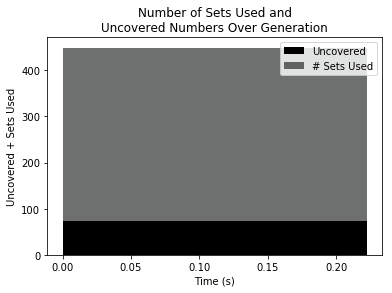

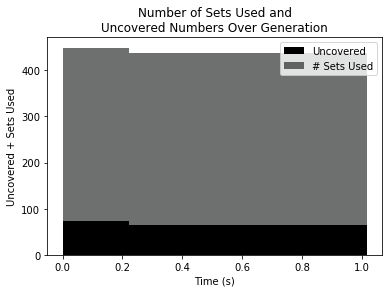

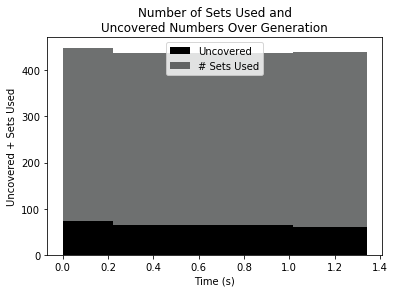

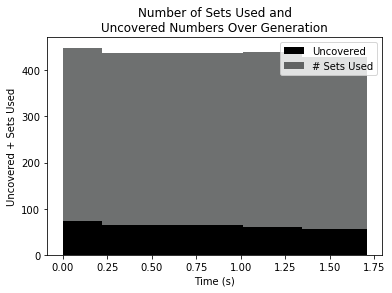

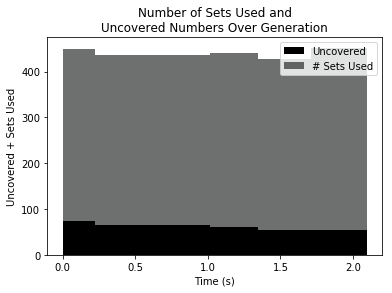

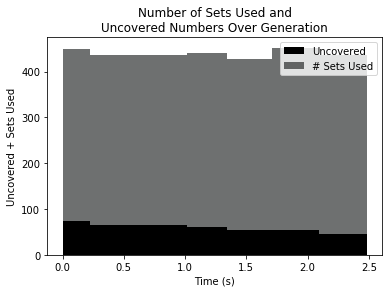

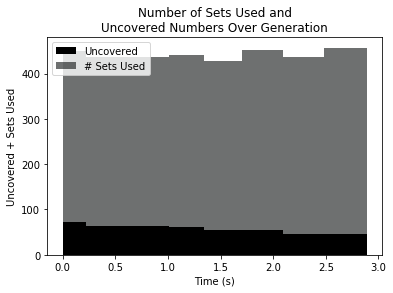

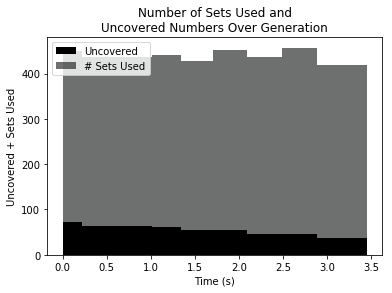

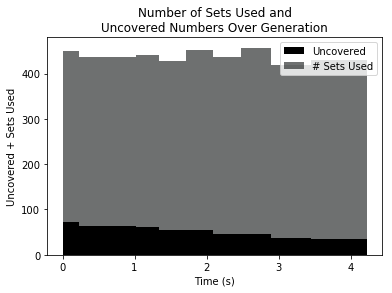

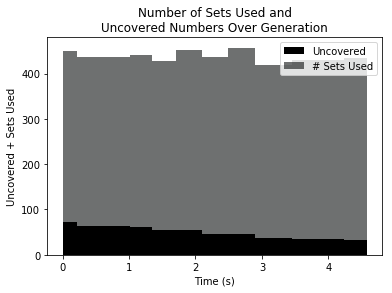

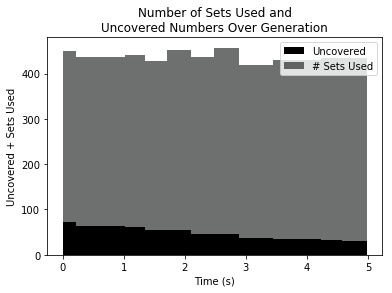

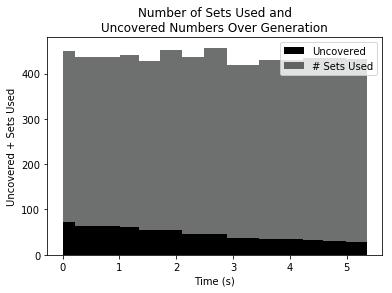

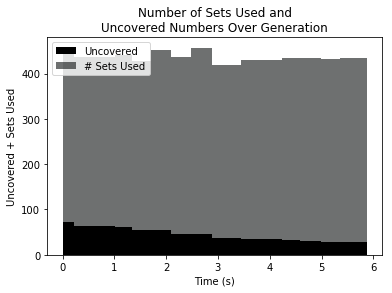

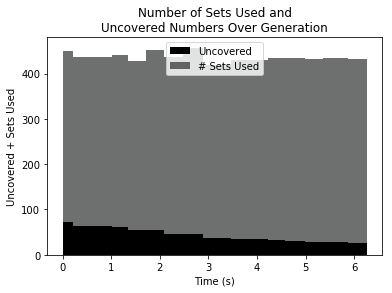

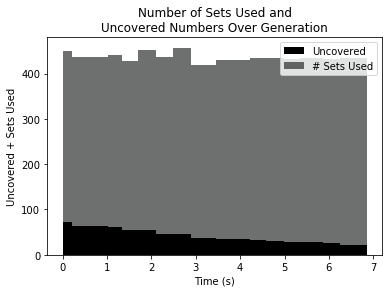

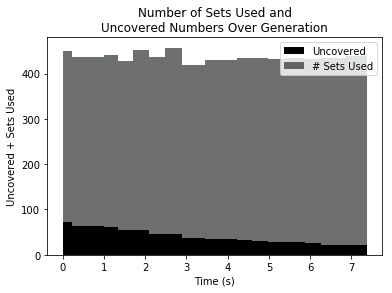

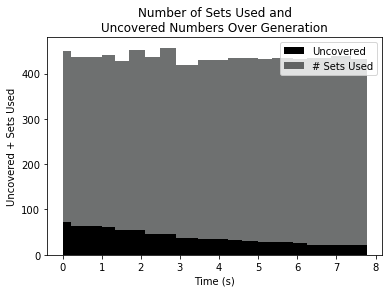

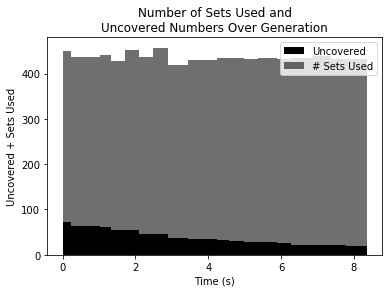

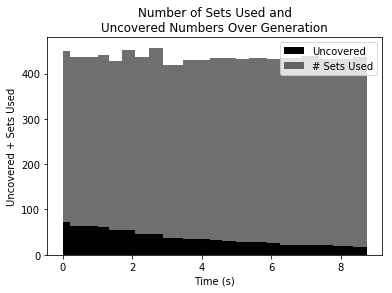

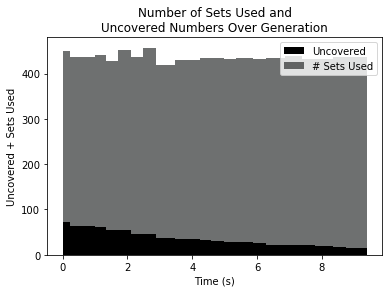

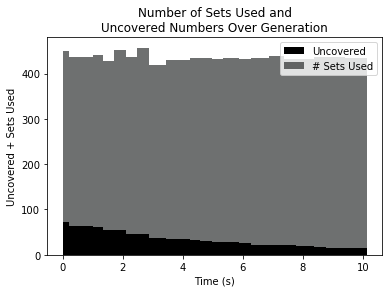

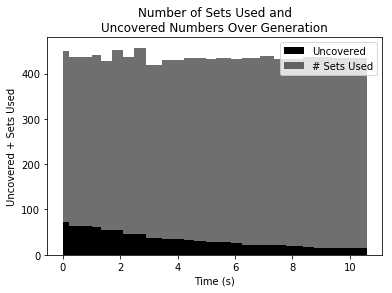

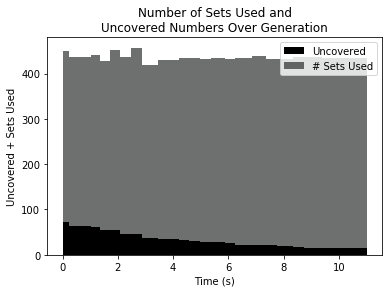

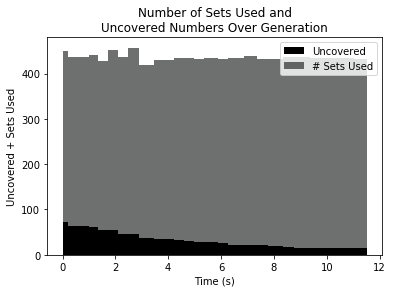

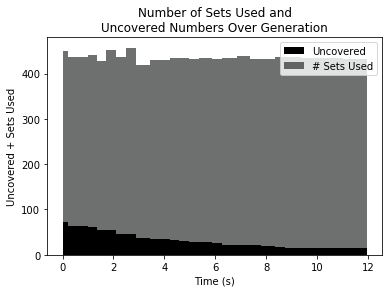

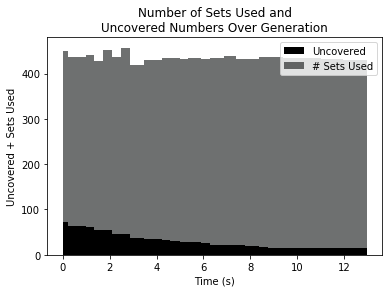

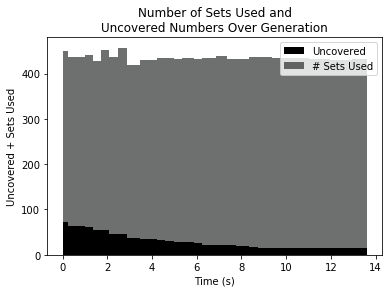

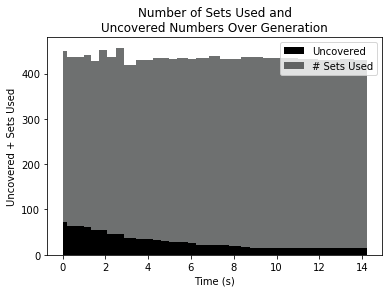

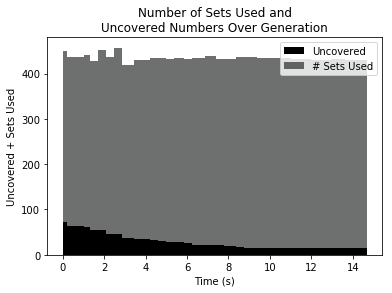

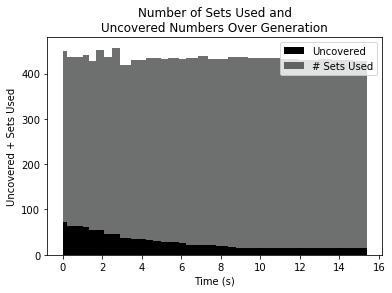

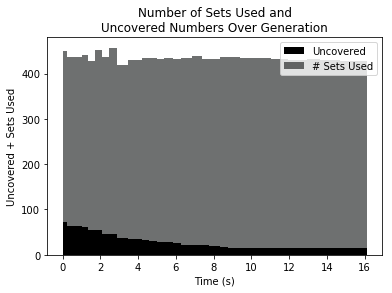

Number Sets: 413	Number of UnCovered: 14
Gen: 2


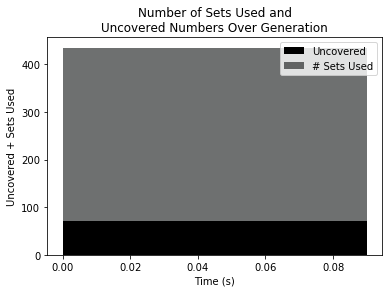

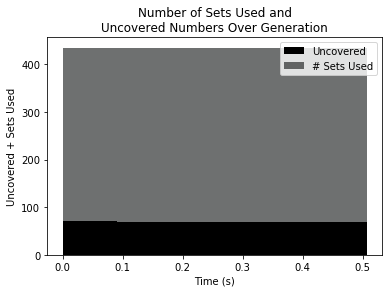

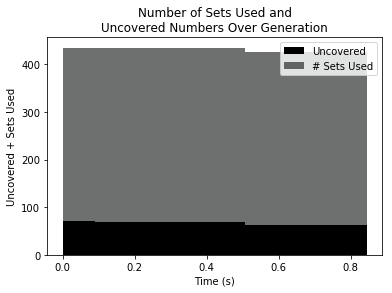

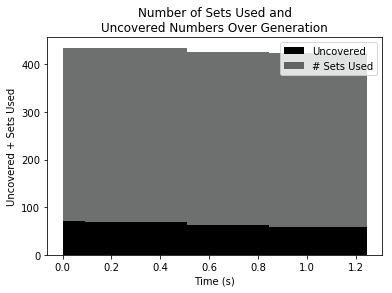

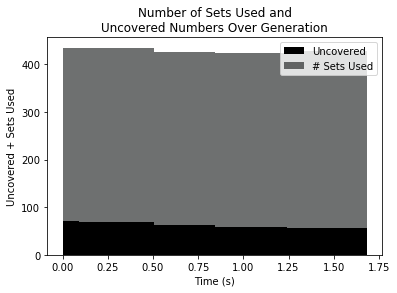

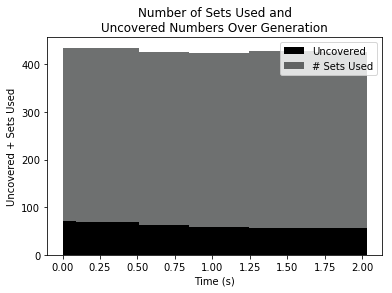

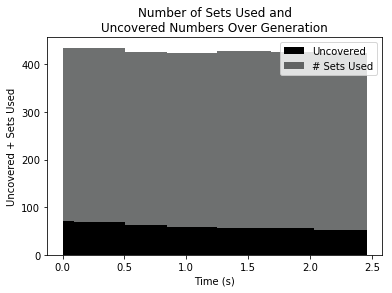

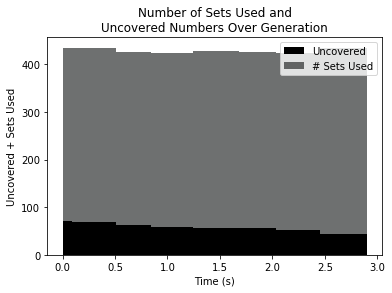

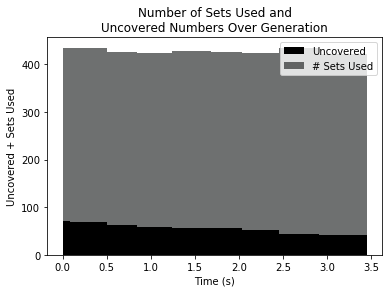

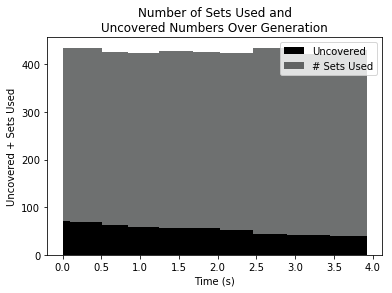

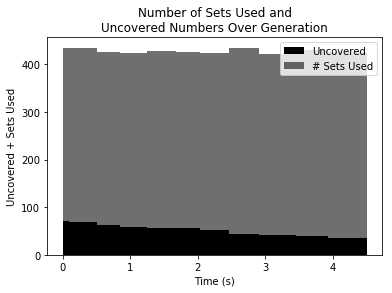

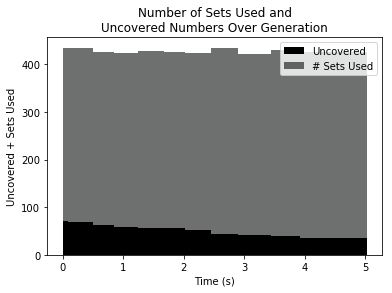

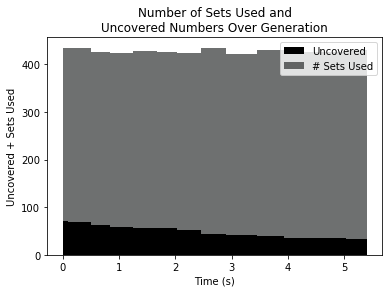

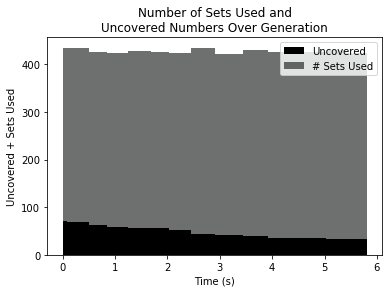

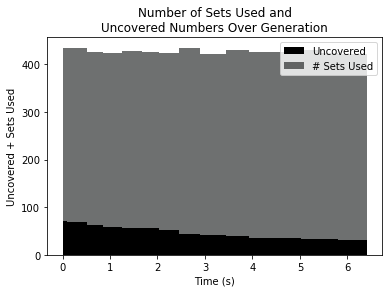

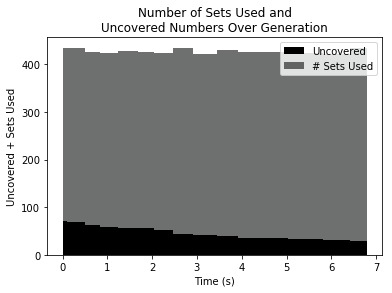

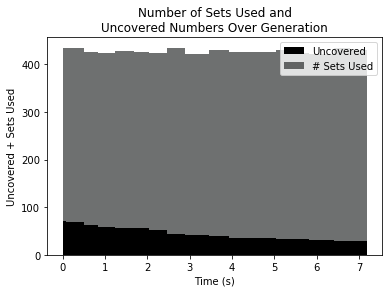

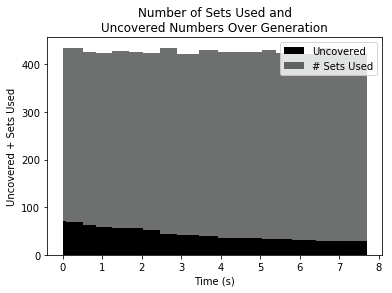

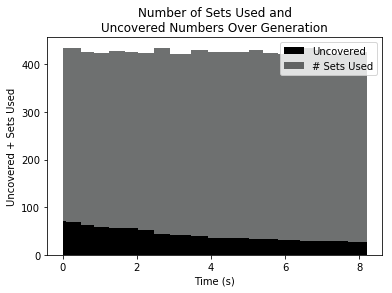

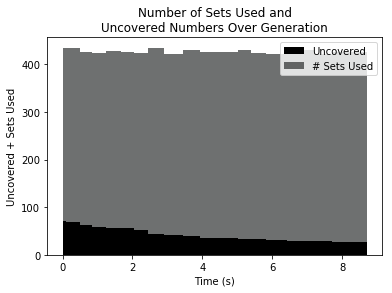

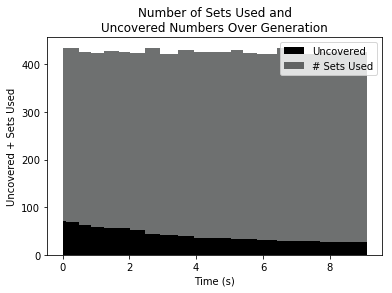

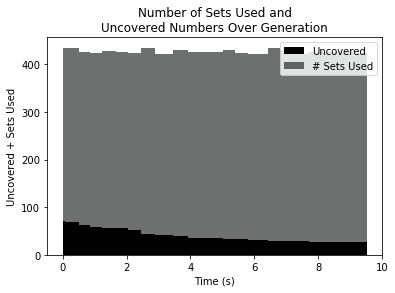

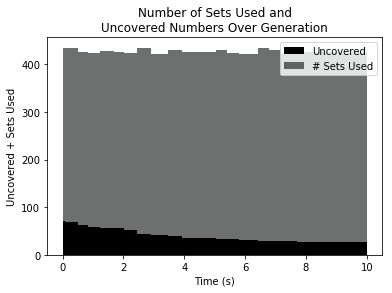

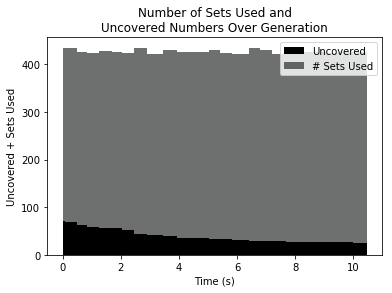

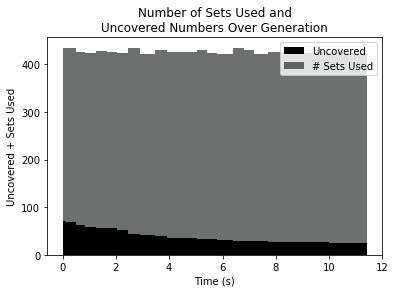

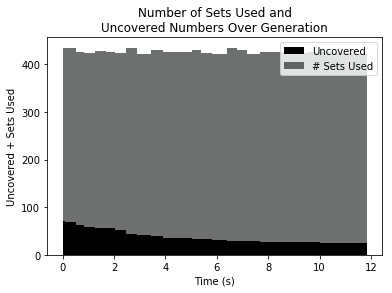

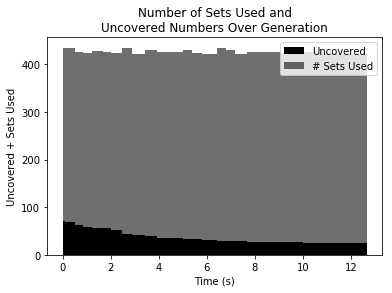

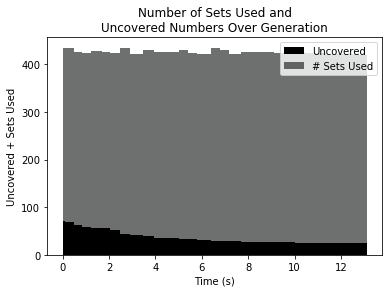

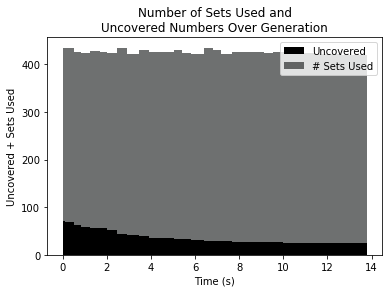

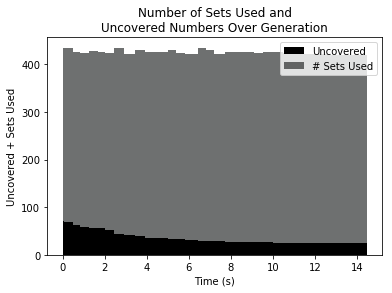

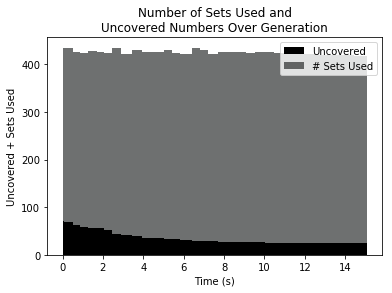

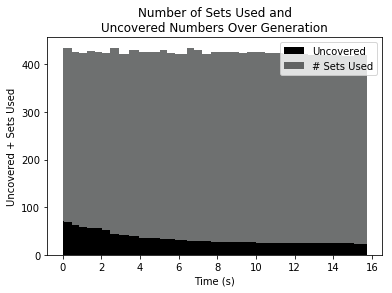

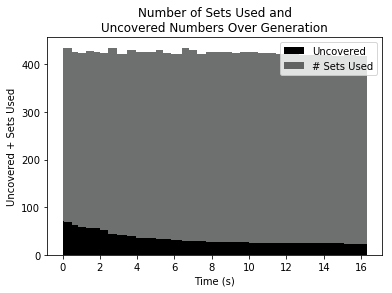

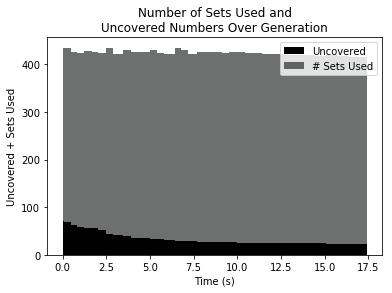

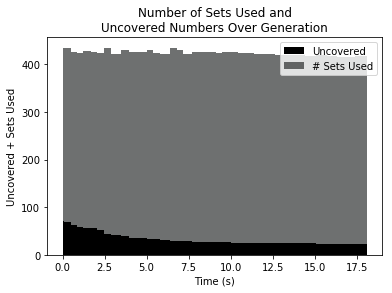

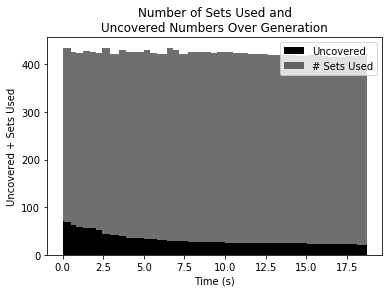

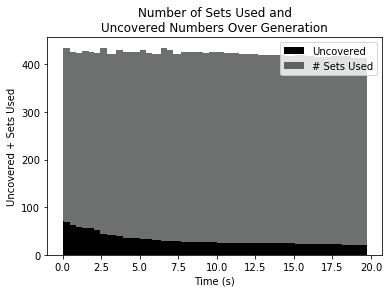

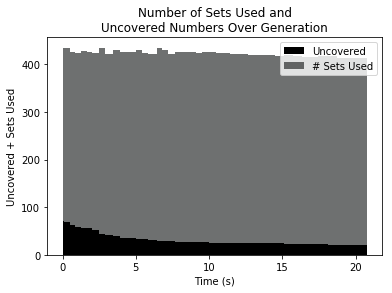

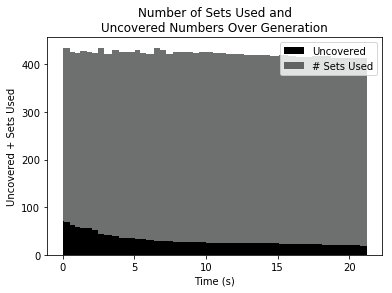

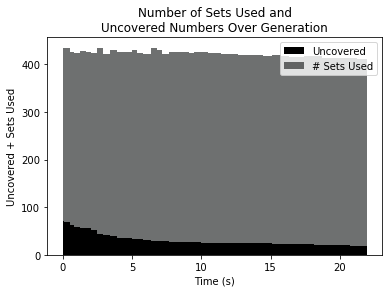

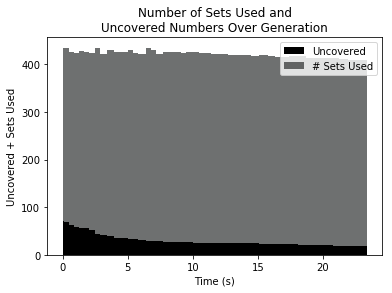

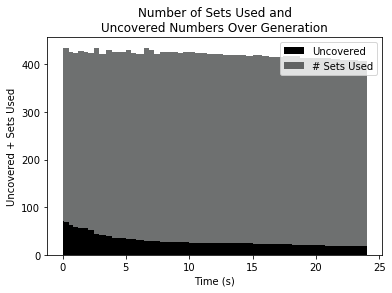

Number Sets: 389	Number of UnCovered: 19
Gen: 3


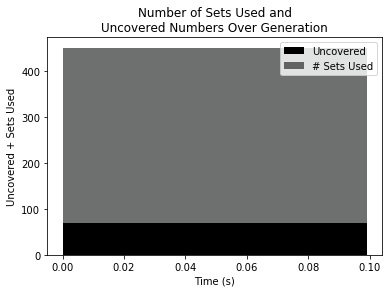

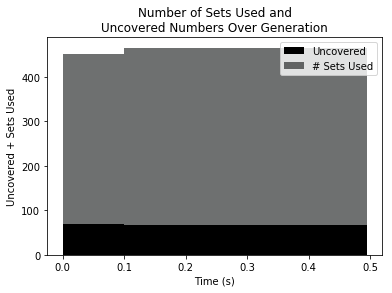

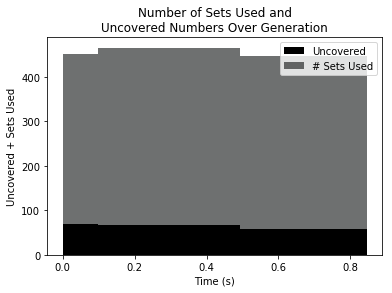

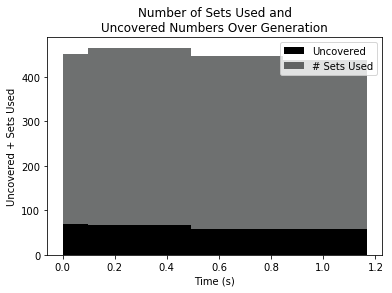

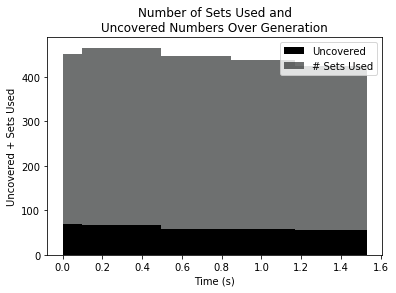

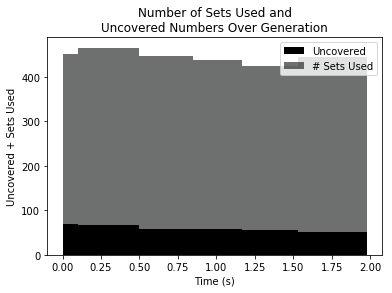

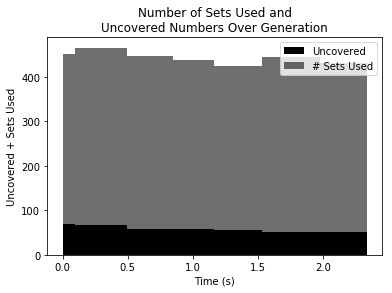

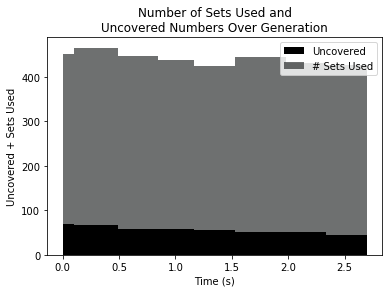

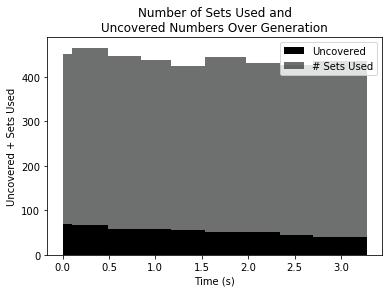

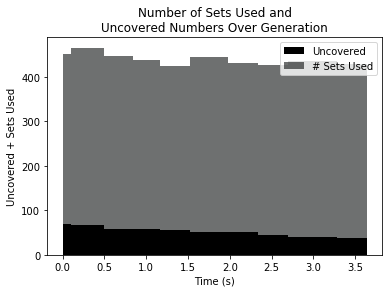

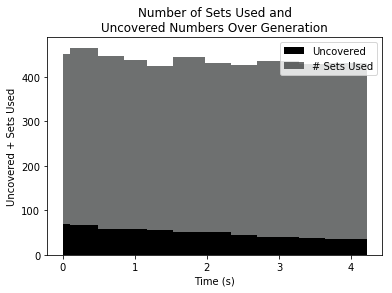

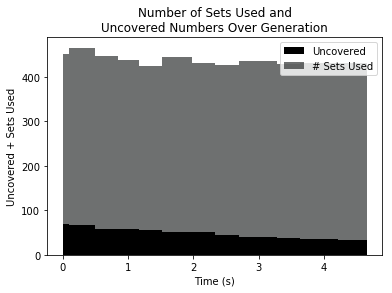

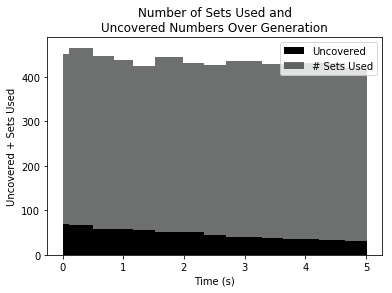

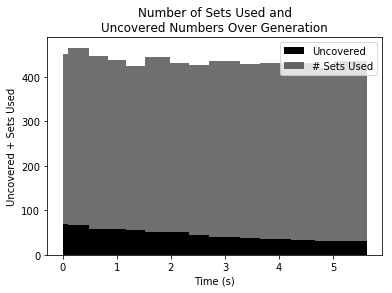

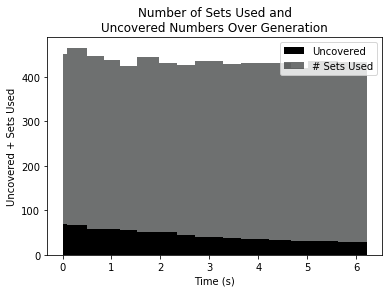

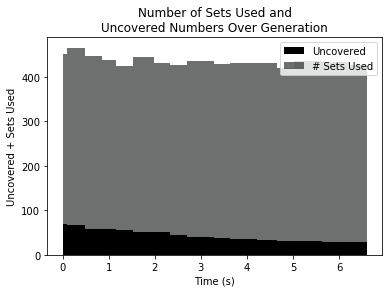

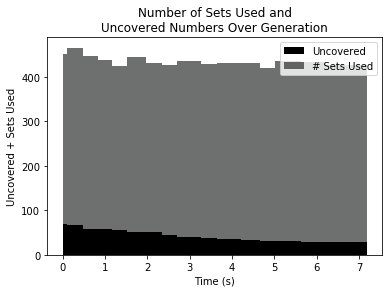

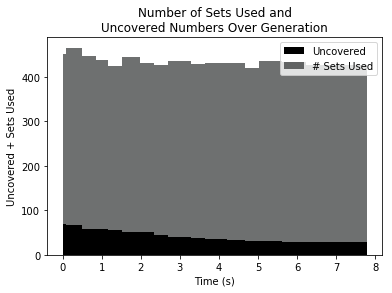

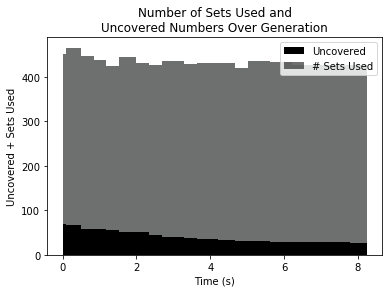

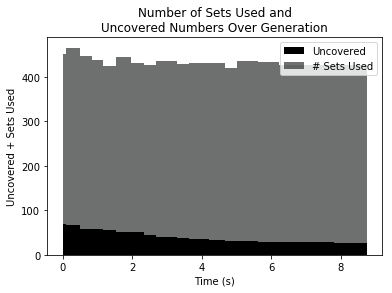

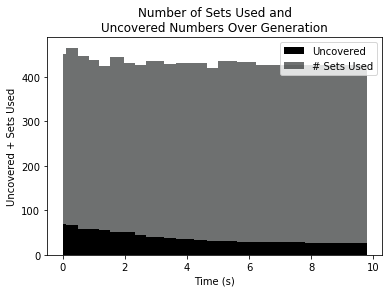

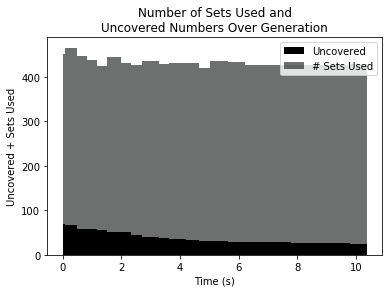

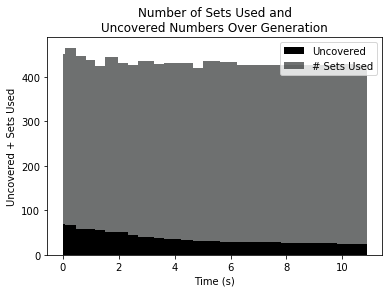

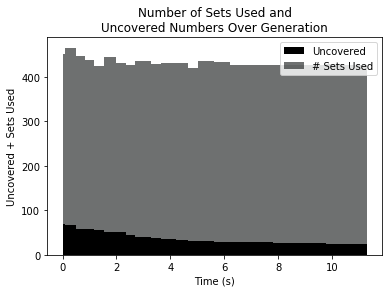

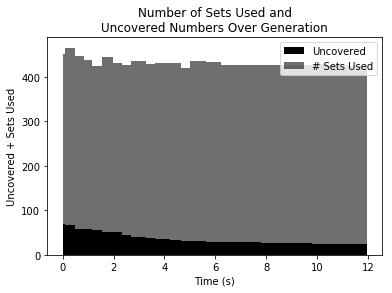

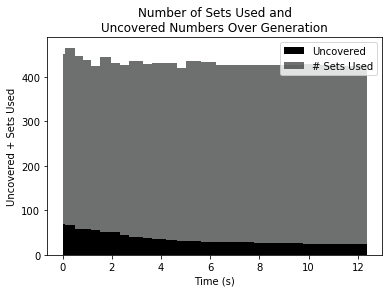

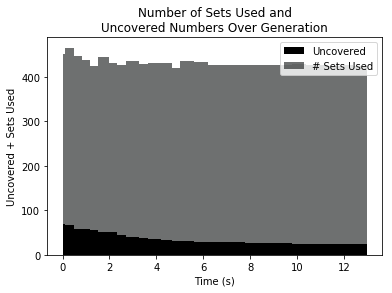

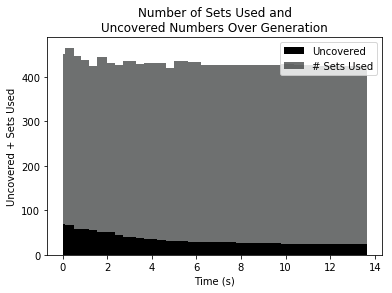

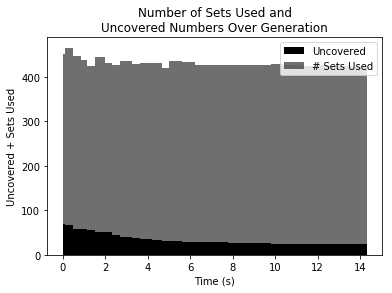

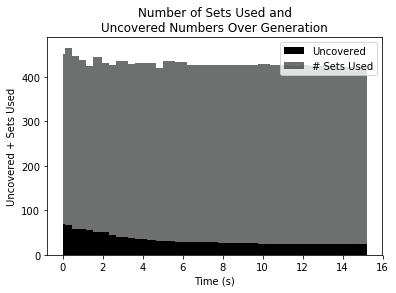

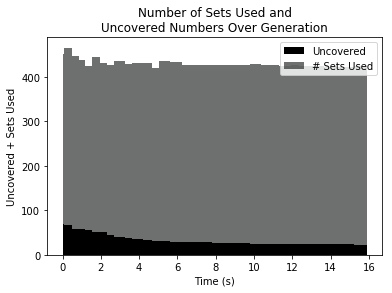

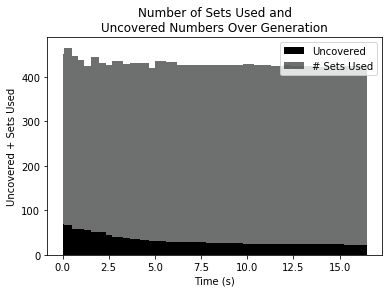

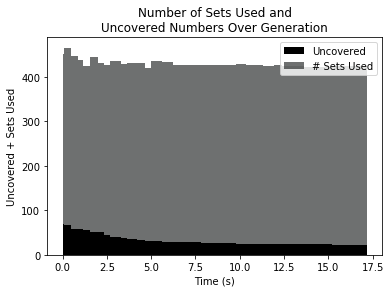

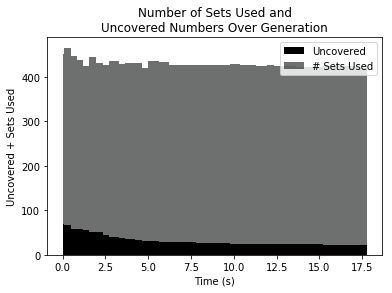

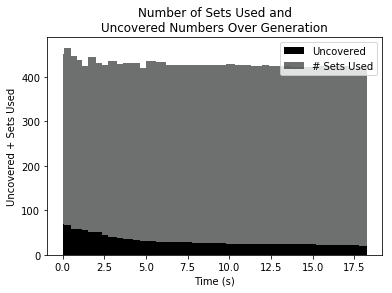

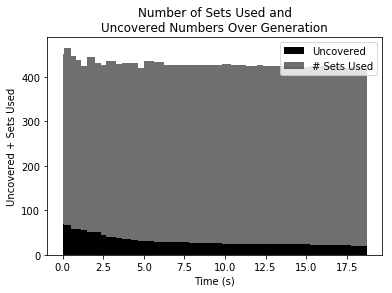

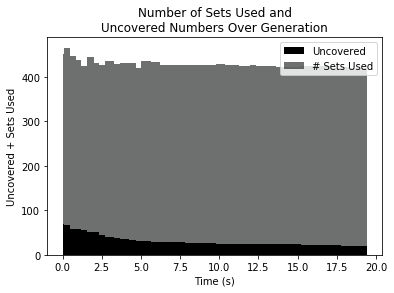

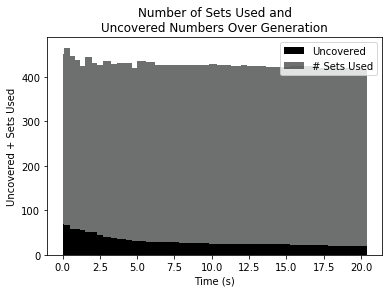

Number Sets: 398	Number of UnCovered: 20
Gen: 4


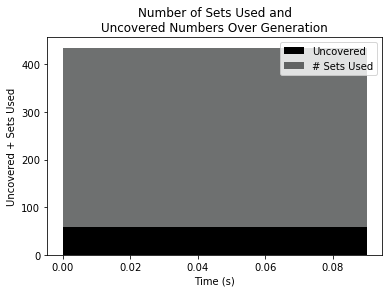

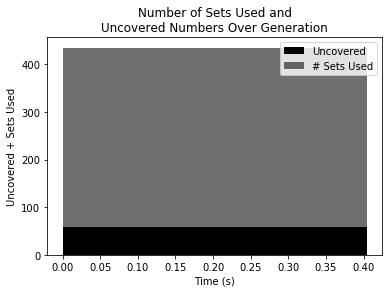

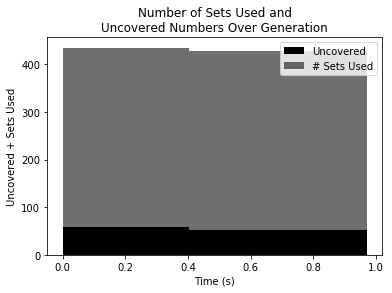

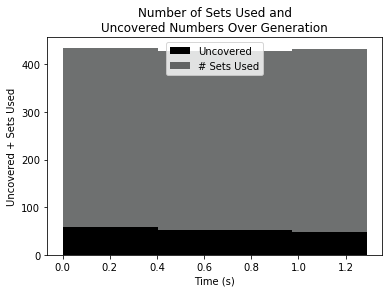

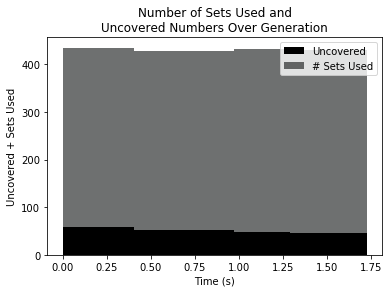

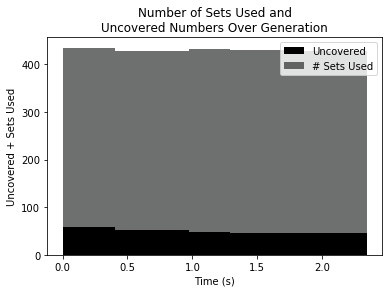

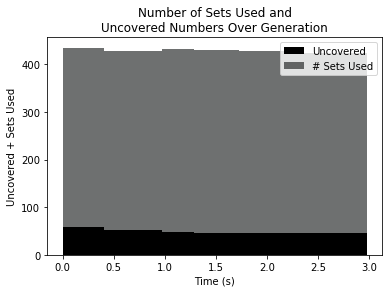

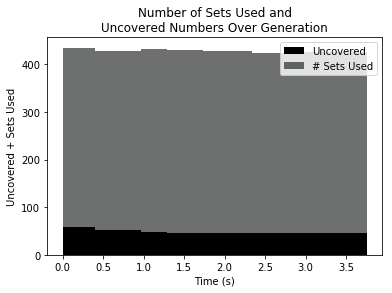

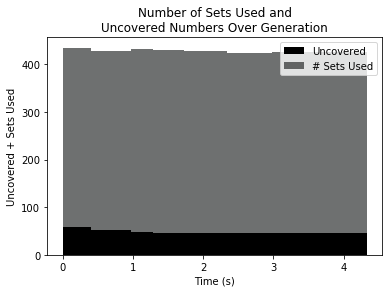

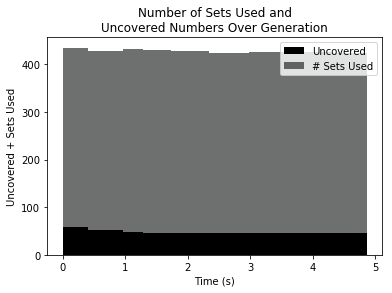

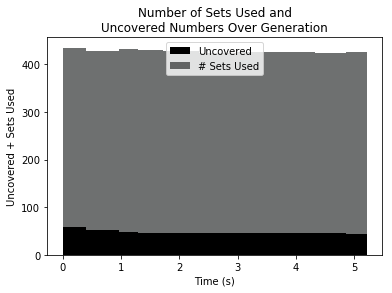

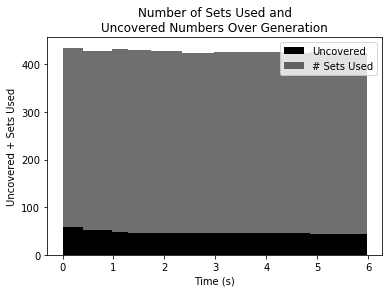

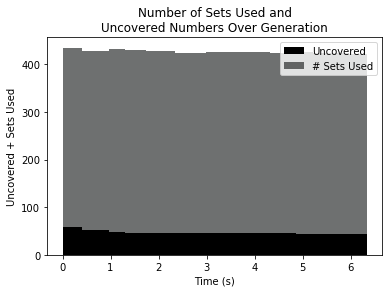

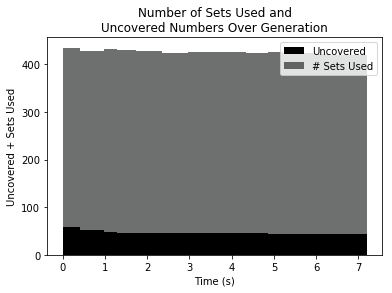

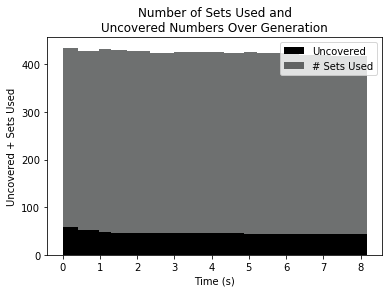

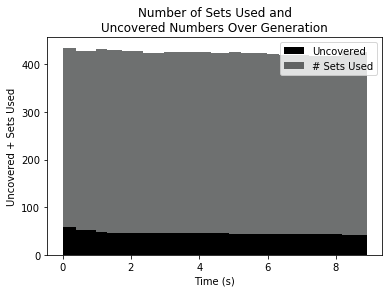

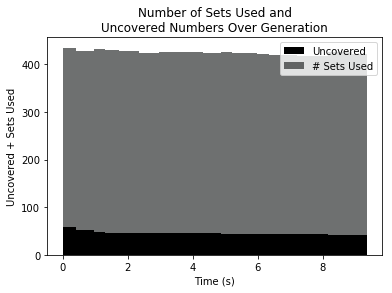

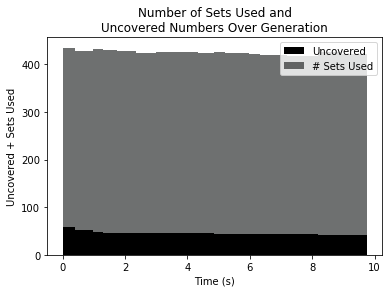

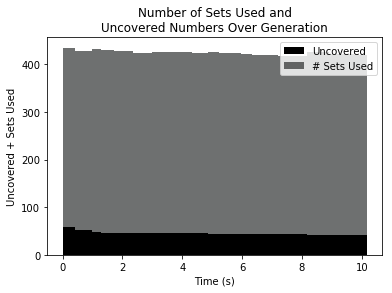

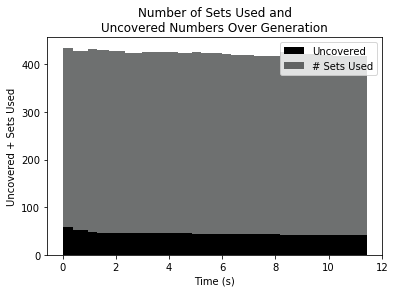

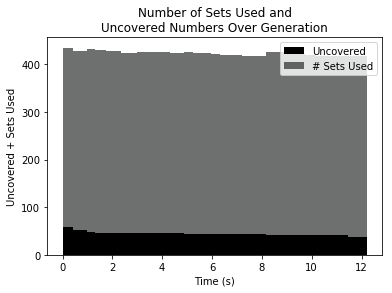

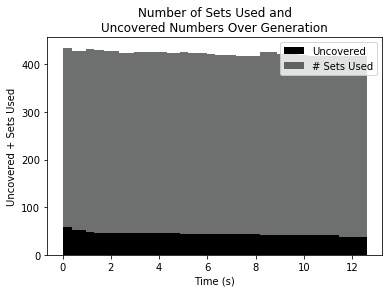

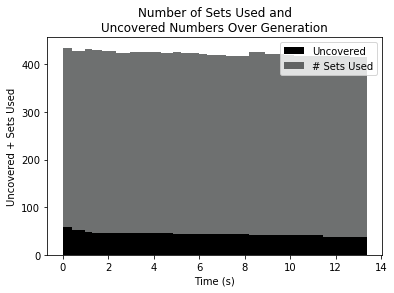

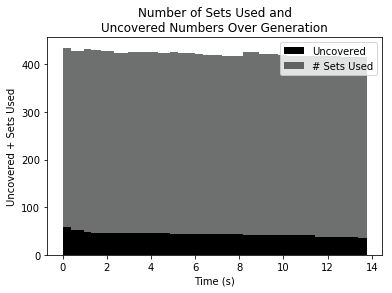

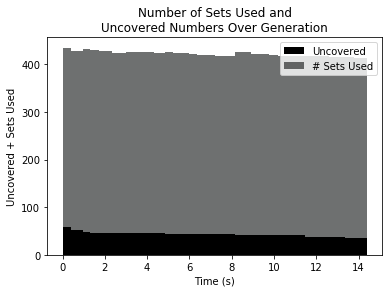

Number Sets: 379	Number of UnCovered: 35
GA Algorithms total run-time: 82.92484402656555
Subsets Used: 83


In [1]:
import itertools
import math 
import matplotlib.pyplot as plt 
import numpy as np
import copy
import time
import random
########################################
#read and parse data file
def read_datafile(path):
    U = []
    #U = set()
    Sets = []
    
    with open((file_path), "r") as file:
        i = 0
        for line in file:
            Set = []
            #if(i == 0):
            #    for num in line.strip().split(","):
            #        U.append(int(num))
            #else:
            for num in line.strip().split(" "):
                Set.append(int(num))
            Sets.append(Set)
            

            if(i == 0):
                for num in line.strip().split(" "):
                    U.append(int(num))
            else:
              for num in line.strip().split(" "):
                newnum = int(num)
                if newnum not in U:
                  U.append(newnum)
            i+=1
                
    return Sets, U

#U = [1,2,3,4,5,6,7,8]
#Sets = [set([1,2]),
#        set([3,4]),
#        set([5,6]),
#        set([7,8]),
#        set([2,4,6,7])]
########################################
class chromosome():
    #A binary representation that shows whether a gene is included or not along with how fit the solution is
    def __init__(self, geneList):
        self.genes = geneList
        self.fitness = math.inf
            
#########################################
def getNumMating(gaPopSize, matingPercentage):
    numMatingChromosomes = int(matingPercentage * gaPopSize)
    if(numMatingChromosomes % 2 == 1 and numMatingChromosomes < gaPopSize):
        numMatingChromosomes += 1
    elif(numMatingChromosomes % 2 == 1 and numMatingChromosomes >= gaPopSize):
        numMatingChromosomes -= 1
    elif(numMatingChromosomes == 0):
        numMatingChromosomes = 2   
    return numMatingChromosomes
    #else even pairs - do nothing  
##############################################################
def pairMates(matingChromosomes, numMatingChromosomes):
    used        = []
    pairedMates = []
    
    i = 1
    j = numMatingChromosomes - 1
    if(i == j):
        topPerformersMate = 1
    else:
        topPerformersMate = np.random.randint(1,j)  
    for pair in itertools.combinations(matingChromosomes,2):
        c1 = pair[0]
        c2 = pair[1]
        
        if(i == topPerformersMate):
            used.append(c1)
            used.append(c2) 
            pairedMates.append(pair)
            i = i+1
            continue
        elif(not(used.__contains__(c1) or used.__contains__(c2)) and i > topPerformersMate):
            used.append(c1)
            used.append(c2)
            pairedMates.append(pair)
        i = i+1   
    return pairedMates
##############################################################
def generateSplitPoint(Sets):
    a = np.random.randint(0,len(Sets))
    b = a
    while(a == b):
        b = np.random.randint(0,len(Sets))   
    
    splitPoint1 = min(a, b)
    splitPoint2 = max(a, b) 
    return splitPoint1, splitPoint2
##############################################################
def Crossover(parent1genes, parent2genes, splitPoint1, splitPoint2, Set):
    tempChromosome = []
    #First section
    tempChromosome = tempChromosome + (list(parent1genes[0:splitPoint1]))

    #Mid Section
    tempChromosome = tempChromosome + (list(parent2genes[splitPoint1:splitPoint2]))
        
    #Last Section    
    tempChromosome = tempChromosome + (list(parent1genes[splitPoint2:]))
            
    return tempChromosome  
##############################################################
def calculate_fitness(chromosomeGenes, Universe):
    #Get number of sets used and return list of uncovered elements
    numSets = 0
    Used = copy.deepcopy(Universe)
    for Set in chromosomeGenes:
        if(Set != 0):
            numSets +=1
            for num in Set:
                if(Used.__contains__(num)):
                    Used.remove(num)
                    
    #Get number of uncovered numbers in Universe
    return numSets, Used
##############################################################
def calculate_fitness2(chromosomeGenes, Universe):
    #Get number of sets used and # uncovered elements
    numSets = 0
    Used2 = []
    for Set in chromosomeGenes:
        if(Set != 0):
            numSets +=1
            Used2 = Used2 + Set
    Used2 = list(dict.fromkeys(Used2))
                    
    #Get number of uncovered numbers in Universe
    return numSets, (len(Universe) - len(Used2))
##############################################################
def sortChromosomes(Population):
    outputPopArr = []
    for chromo in Population:
        dist = chromo.fitness
        if(len(outputPopArr) == 0):
            outputPopArr.append(chromo)
        else:
            i = 0
            added = False
            for outChromo in outputPopArr:
                if(outChromo.fitness >= dist):
                    outputPopArr.insert(i, chromo)
                    added = True
                    break
                else:
                    #if chromosome is larger than all current, place at end
                    i += 1
            if(not added):
                outputPopArr.append(chromo)
    return outputPopArr


########################
#TESTING
########################
NumGAPopulations = 4
gaPopSize        = 50
numNoChangeGen   = 15
mutationChance   = 100

#######
#INPUT
######

#Read Data File
file_path = str(r'SCP Datasets/scp44.txt')
#used to read and parse the scp file
Universe = []
Sets     = []
Weights  = []

Sets, Universe = read_datafile(file_path)
crowd = [0] * len(Sets)
fittest = []
prevdist = (math.inf, math.inf)

#print('The subsets are:', Sets)
#print('The universal set is:', Universe)

#######################
#Adding Random Weights
#######################
count = 0
 #Strips the newline character
for sets in Sets: 
    num1 = random.randint(1, 9)
    count += 1
    Weights.append(num1)
#print(Weights)

###############################
#START MULTIPLE GA POPULATIONS
##############################

StartTime = time.time()

for pop in range(NumGAPopulations):
    setsUsedArr = []
    numUncoveredArr = [] 
    ind      = []
    width    = []
    prevTime = 0
    StartTimePop = time.time()
    print("Gen: " + str(pop+1))
############
#INITIALIZE
###########

    #Create population of chromosomes - binary lists
    Population = []
    #create array of nodes
    for i in range(gaPopSize):
        geneList = [0]
        while(not geneList.__contains__(1)):
            geneList = list(np.random.randint(2, size=len(Sets)))
        j = 0
        for gene in geneList:
            if(gene == 1):
                geneList[j] = Sets[j]
            j+=1
        chromo = chromosome(geneList)
        Population.append(chromo)
    
    ###########################################################################
    genNumber = 0
    noChange = 0
    while(numNoChangeGen > noChange):
        #################################
        #TEST FITNESS OF EACH CHROMOSOME
        ################################
        #Measure trip distance
        for i in (range(len(Population))):
            numSetsUsed = 0
            NotCovered = []
            fitness = []
            
            numSetsUsed, NotCovered = calculate_fitness2(Population[i].genes, Universe) #NotCovered,numSetsUsed
            fitness = (NotCovered, numSetsUsed)
            Population[i].fitness = fitness
    
        #############################
        #SELECT FITTEST CHROMOSOMES
        ###########################
        #Percent of chromosomes to mate
        matingPercentage = .5
        #get number of chromosomes to mate
        numMatingChromosomes = getNumMating(gaPopSize, matingPercentage)
        
        #sort based on fittness -AKA smallest distance is first
        Population = sortChromosomes(Population)
        
        #Find and select n fittest chromosomes - select the numMatingChromosomes number of chromosomes that are fittest
        matingChromosomes = Population[0:numMatingChromosomes]
        
        #Pair mates somewhat randomly
        pairedMates = pairMates(matingChromosomes, numMatingChromosomes)
        
        
        ##################################
        #Graph Current Fittest chromosome -Graphs best fitness on each iteration with change
        #################################
        fittest.append(Population[0].fitness)
        
        #check if a new optimum is found
        if(prevdist != Population[0].fitness):
            plt.clf()
        
            setsUsedArr.append(Population[0].fitness[0])
            numUncoveredArr.append(Population[0].fitness[1])

            CurrentTime = time.time() - StartTimePop     
            c2 = (CurrentTime - prevTime)/2 + prevTime
            ind.append(c2)

            width.append((CurrentTime - prevTime))       # the width of the bars                
            
            prevTime = CurrentTime
            
            p1 = plt.bar(ind, setsUsedArr, width, color=(0, 0, 0, 1))
            p2 = plt.bar(ind, numUncoveredArr, width, bottom=setsUsedArr, color=(0, .01, .01, .57))
            
            plt.ylabel('Uncovered + Sets Used')
            plt.xlabel('Time (s)')
            plt.title('Number of Sets Used and\nUncovered Numbers Over Generation')

            plt.legend((p1[0], p2[0]), ('Uncovered', '# Sets Used'))
            plt.pause(.05)
            plt.show() 
            
            bestDist = Population[0].fitness
            
            noChange = 0
        else:
            noChange +=1
        
        prevdist = Population[0].fitness
        
        #######################
        #CROSSOVER - TWO POINT
        ######################
        
        #Split chromosome at split Point
        tempChromosome1 = []
        tempChromosome2 = []
        i = 0
        for mates in pairedMates:
            #index of chromosome to be split at for crossover
            splitPoint1, splitPoint2 = generateSplitPoint(Sets)
            
            #Get parent genes
            parent1genes = mates[0].genes
            parent2genes = mates[1].genes
            
            #pull first n nodes from parent1 til min split point
            tempChromosome1 = Crossover(parent1genes, parent2genes, splitPoint1, splitPoint2, Sets)
            tempChromosome2 = Crossover(parent2genes, parent1genes, splitPoint1, splitPoint2, Sets)
        
            #replace genes in worst performers in initial population
            Population[(gaPopSize - i - 1)].genes = tempChromosome1       
            Population[(gaPopSize - i - 2)].genes = tempChromosome2     
        
            i += 2  #increment by two since we are doing two genes per iteration      
        
               
        ###########
        #MUTATION
        #########
        #1 in mutation chance: chance of mutation occurring on gene
        for chromo in Population[:]:
            i = 0 #tracks gene's index
            
            #Determine how many mutations should occur if any 
            mutationIndicator = np.random.randint(1,mutationChance)
            
            if(mutationIndicator == 1): #Mutation Occurs
                #select how many genes to mutate
                mutations = np.random.randint(1,10)
                
                for i in range(mutations):
                    mutationIndex = np.random.randint(0,(len(chromo.genes)))
                    if(chromo.genes[mutationIndex] == 0):
                        chromo.genes[mutationIndex] = Sets[mutationIndex]
                    else:
                        chromo.genes[mutationIndex] = 0
        genNumber += 1
    
    #Print Data:
    print("Number Sets: " + str(bestDist[1]) + "\tNumber of UnCovered: " + str(bestDist[0]))
    #Once Population is done, enumerate the frequency for which a set is used into crowd
    for i in range(len(Sets)):
        for chromo in matingChromosomes:
            if(chromo.genes[i] != 0):
                crowd[i] += 1

GAEndTime = time.time()

CurrentTime = GAEndTime - StartTime

print("GA Algorithms total run-time: " + str(CurrentTime))

###################################
#Use Crowd to find Typical Solution
##################################                

#iterate through table and select 85% edge agreement
i = 0
notUsed = 0
numSetsUsed = 0
NotCovered = []
fitness = []

percent = .85
Included = [0] * len(Sets)
for gene in crowd:
    if(gene >= (int(percent * NumGAPopulations * len(matingChromosomes)))):
        Included[i] = Sets[i]
    else:
        notUsed += 1
    i+=1


bestCover = len(NotCovered)

print("Subsets Used: " + str(calculate_fitness(Included, Universe)[0]))